# Nhập môn Khoa học Dữ liệu - Đồ án cuối kỳ

Thành viên thực hiện
- 18127123 - Nguyễn Trung Kiên
- 18127203 - Nguyễn Lê Quốc Tài


## 1. Thu thập dữ liệu

### 1.1. Nguồn thu thập dữ liệu

- Url: http://vetaugiare24h.com/ve-xe.html
- Mô tả trang web:
 - Term of service: Không có
 - Nội dung: Tra cứu thông tin vé xe khách đi toàn quốc
- Dữ liệu thu thập là thông tin của từng chuyến đi, bao gồm
 - Điểm đi
 - Điểm đến
 - Số chỗ
 - Giá (VNĐ)

### 1.2. Thu thập dữ liệu từ trang web

- Ở đây, để tiện cho việc tái sử dụng lại dữ liệu và tránh mất thời gian thu thập lại (từ internet cũng như cache), nhóm đã tách riêng thành một file **CollectData.ipynb** chỉ dùng để crawl. Dữ liệu sau đó được lưu dưới dạng file tsv, các bước xử lí sau này, ta sẽ gọi trực tiếp file tsv này lên.
- Trong trường hợp muốn thu thập lại dữ liệu, ta sẽ phải run lại file .**CollectData.ipynb** ở trên, tuy nhiên thời gian chạy sẽ khá lâu,
 - Internet ≈ 90 phút
 - Cache ≈ 7 phút
- File cache có được từ việc parse trang web. [Link](https://drive.google.com/file/d/1wNJnwGl2Q12KXGVIUg-7SKlh5vfcB9yX/view?usp=sharing)
- Trong trường hợp không parse trang web (tránh mất thời gian), dùng file tsv sau, có được từ việc thu thập. [Link](https://drive.google.com/file/d/11lb9wj1x3ENuMsUTGFlGk2ROI2wmV743/view?usp=sharing)

In [1]:
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn import set_config

set_config(display='diagram')     # Trực quan hóa pipeline
warnings.filterwarnings('ignore') # Ẩn tất cả warnings

Kiểm tra môi trường code

In [2]:
import sys
sys.executable

'C:\\Users\\Kien\\anaconda3\\envs\\min_ds-env\\python.exe'

## 2. Khám phá dữ liệu

### Nhìn qua dữ liệu đã thu thập được.

In [3]:
df = pd.read_csv('tickets.tsv', sep='\t')
df.head()

,Điểm đi,Điểm đến,Số chỗ,Giá (VNĐ)
0,An Giang,Hà Nội,40.0,900000.0
1,Bà Rịa -Vũng Tàu,Hà Nội,40.0,800000.0
2,Bà Rịa -Vũng Tàu,Hà Nội,42.0,700000.0
3,Bà Rịa -Vũng Tàu,Hà Nội,40.0,850000.0
4,Bắc Giang,Hà Nội,28.0,50000.0


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
df.shape

(10692, 4)

### Dữ liệu có gì bất thường không?

In [5]:
df.describe()

,Số chỗ,Giá (VNĐ)
count,10692.000000,1.069200e+04
mean,36.679761,2.345294e+05
std,10.330193,1.852427e+05
min,7.000000,2.000000e+04
25%,39.000000,1.100000e+05
50%,40.000000,1.800000e+05
75%,44.000000,2.800000e+05
max,120.000000,1.400000e+06


Ở đây có điều bất thường. Tại cột "Số chỗ" ta thấy max là 120, điều này là vô lý, có thể là do lúc nhập liệu bên phía website bị nhầm.

Do đó, ta sẽ xóa các dòng mà tại đó, cột "Số chỗ" bằng 120.

In [6]:
df = df.drop(df[df['Số chỗ'] == 120].index)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng chứa thông tin của một tuyến xe và không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

In [7]:
df.duplicated().sum()

6469

Ta thấy rằng có nhiều dòng bị lặp. Điều này là do ở cột "Điểm đi" và "Điểm đến" còn có mốc **thời gian khởi hành** và **thời gian đến** khác nhau (kiểm tra trực tiếp tại trang web) nhưng ta không lấy thông tin này về, do đó dữ liệu bị lặp.

In [8]:
new_df = df.drop_duplicates()
new_df.shape

(4221, 4)

## 3. Đưa ra câu hỏi cần trả lời

- **Câu hỏi:** Có công thức nào để dự đoán được giá vé xe khi biết thông tin về điểm đi, điểm đến và số chỗ ngồi trên xe hay không?

- **Ý nghĩa khi trả lời câu hỏi trên:** Doanh nghiệp vận tải muốn mở một tuyến đường mà *chưa có doanh nghiệp nào khai thác* thì việc tham khảo cũng như đưa ra mức giá là khá khó; đối với các tuyến đã có người khai thác thì chỉ cần tham khảo giá của họ rồi hiệu chỉnh, áp dụng. Do đó, trả lời được câu hỏi này sẽ giúp doanh nghiệp đưa ra được giá vé hợp lý dựa theo ba tiêu chí: điểm đi, điểm đến và số chỗ.

## 4. Tiền xử lý dữ liệu

Các cột dạng số (numerical) và không phải dạng số (categorical).

In [9]:
nume_cols = ['Số chỗ']
cate_cols = ['Điểm đi', 'Điểm đến']

Format lại tên một số tỉnh thành. Lát nữa ta sẽ dùng OneHotEncoder để chuyển dữ liệu ở hai cột "Điểm đi" và "Điểm đến" thành dạng số.

In [10]:
# Chữ trong các cột dạng categorial chuyển thành chữ thường
new_df[cate_cols] = new_df[cate_cols].applymap(lambda s: s.lower())

# Các lỗi trong tập dữ liệu (a)
a = ['bà rịa -vũng tàu', 'nha trang khánh hòa', 'nha trang', 'thừa thiên huế', \
     'vinh nghệ an', 'vinh', 'điện biên phủ', 'tphcm sài gòn', 'đà lạt', 'tuy hòa']
# ... mà ta cần format lại (b)
b = ['vũng tàu', 'khánh hòa', 'khánh hòa', 'huế', \
     'nghệ an', 'nghệ an', 'điện biên', 'sài gòn', 'lâm đồng', 'phú yên']

# Sửa trên các cột dạng categorical
new_df[cate_cols] = new_df[cate_cols].replace(a, b)

Kiểm tra lại xem sau khi format thì các loại giá trị của hai cột đã giống nhau hay chưa?

In [11]:
set(new_df['Điểm đi'].unique()) == set(new_df['Điểm đến'].unique())

True

In [12]:
len(new_df['Điểm đi'].unique())

63

Save lại để sử dụng về sau hoặc để kiểm tra lại dữ liệu sau khi được xử lý (bằng mắt).

In [13]:
new_df.to_csv('preprocessed_tickets.tsv', sep='\t', index=False)

### 4.1. Tách các tập

Tách tập dữ liệu thành 3 tập: train, validation và test theo tỉ lệ 60/20/20.

In [14]:
# Tách X và y
y = new_df['Giá (VNĐ)']
X = new_df.drop('Giá (VNĐ)', axis=1)

In [15]:
# Tách thành train (80%) và test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Tách thành train (60%) và val (20%)
# 0.8 * 0.25 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [16]:
# Kích thước của X_train, X_val, X_test
print(f'X_train = {X_train.shape}')
print(f'X_val   = {X_val.shape}')
print(f'X_test  = {X_test.shape}')

X_train = (2532, 3)
X_val   = (844, 3)
X_test  = (845, 3)


### 4.2. Tiền xử lý tập train

- Với cột dạng số `nume_cols`, ta giá trị thiếu bằng giá trị mean của cột.
- Với cột không phải dạng số `cate_cols`
  - Ta điền giá trị thiếu bằng giá trị xuất hiện nhiều nhất của cột.
  - Sau đó, chuyển sang dạng số bằng phương pháp one-hot encoder.
- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa.

In [17]:
# Các cột dạng số
nume_transformer = SimpleImputer(strategy='mean')

# Các cột không phải dạng số
cate_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore')),
])

# Tổng hợp 2 transformer bên trên lại
Preprocessor = ColumnTransformer(
    transformers=[
        ('cate', cate_transformer, cate_cols),
        ('nume', nume_transformer, nume_cols),
    ])

# Tạo pipeline
preprocess_pipeline = Pipeline(steps=[
    ('impute_encode', Preprocessor),
    ('scale', StandardScaler(with_mean=False)),
])

In [18]:
preprocess_pipeline

Pipeline(steps=[('impute_encode',
                 ColumnTransformer(transformers=[('cate',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Điểm đi', 'Điểm đến']),
                                                 ('nume', SimpleImputer(),
                                                  ['Số chỗ'])])),
                ('scale', StandardScaler(with_mean=False))])

In [19]:
# Fit pipeline với X_train
preprocessed_X_train = preprocess_pipeline.fit_transform(X_train)

In [20]:
# Kích thước của X_train sau khi đưa qua pipeline
preprocessed_X_train.shape

(2532, 127)

In [21]:
# Nhìn qua tập train sau khi được xử lý
pd.DataFrame(preprocessed_X_train.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.376187
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.376187
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.256716
3,0.0,11.026323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.137245
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.778833


## 5. Mô hình hóa dữ liệu

Tạo full pipeline.

In [22]:
mlpr = MLPRegressor(solver='lbfgs', random_state=0, max_iter=10000)

full_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('regressor', mlpr)
])
full_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('impute_encode',
                                  ColumnTransformer(transformers=[('cate',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Điểm đi',
                                                                    'Điểm '
                                                                    'đến']),
                                                                  ('nume',
                                                                   SimpleImputer(),
                                                                   ['Số '
                                                                    'chỗ'])])),
                                 ('scale', StandardScaler(with_mean=False))])),
                ('regressor',
                 MLPRegressor(max_iter=10000, random_state=0, solver='lbfgs'))])

Thử nghiệm các giá trị khác nhau của các siêu tham số và chọn ra giá trị tốt nhất.

In [23]:
train_errs = []
val_errs = []
hidden_layer_sizes = [(10, 5), (20, 10), 20, 15]
alphas = [0.001, 0.01, 0.1, 1]

best_val_err = float('inf')
best_alpha = None
best_hidden_layer_size = None

for alpha in alphas:
  for hidden_layer_size in hidden_layer_sizes:

    full_pipeline.set_params(regressor__hidden_layer_sizes=hidden_layer_size, 
                             regressor__alpha=alpha)
    
    model = full_pipeline.fit(X_train, y_train)

    train_err = (1 - model.score(X_train, y_train)) * 100
    train_errs.append(train_err)
    
    val_err = (1 - model.score(X_val, y_val)) * 100
    val_errs.append(val_err)

    if val_err < best_val_err:
      best_val_err, best_alpha, best_hidden_layer_size = val_err, alpha, hidden_layer_size
    
'Finish!'

'Finish!'

Trực quan hóa kết quả bằng heatmap. *Code này được tham khảo từ HW3 của thầy* :")

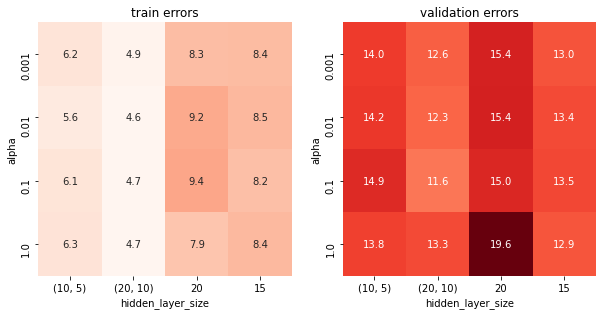

In [24]:
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1), index=alphas, columns=hidden_layer_sizes)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), index=alphas, columns=hidden_layer_sizes)

min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('hidden_layer_size'); plt.ylabel('alpha')

plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('hidden_layer_size'); plt.ylabel('alpha');

NHẬN XÉT
- Càng nhiều số tầng ẩn và nơron ẩn thì độ lỗi trên cả hai tập càng giảm, `hidden_layer_size` tốt nhất trong 4 trường hợp là (20,10).
- Ta kỳ vọng alpha quá cao thì độ lỗi trên cả hai tập cao (underfitting) và alpha quá thấp thì độ lỗi trên tập train thấp nhưng trên tập validation cao (overfitting). Tuy nhiên thực tế alpha biến động không như kỳ vọng. Một nguyên nhân có thể là dữ liệu ban đầu có nhiều cực trị địa phương.
<hr>

In [25]:
print(f'best_val_err = {best_val_err}')
print(f'best_alpha   = {best_alpha}')
print(f'best_hidden_layer_size = {best_hidden_layer_size}')

best_val_err = 11.573220078894453
best_alpha   = 0.1
best_hidden_layer_size = (20, 10)


Mô hình tốt nhất thu được dựa trên độ lỗi trên tập validation ở trên.

In [26]:
full_pipeline.set_params(regressor__hidden_layer_sizes=best_hidden_layer_size, 
                         regressor__alpha=best_alpha)
model = full_pipeline.fit(X_train_val, y_train_val)

Độ lỗi trên tập test.

In [27]:
test_err = (1 - model.score(X_test, y_test)) * 100
test_err

13.016593561057665

## 6. Cảm nghĩ

### 6.1. Nguyễn Trung Kiên
- **Những khó khăn đã gặp phải**
  - *Khó khăn trong việc tiền xử lý dữ liệu:* Dữ liệu tại một số dòng không hợp lý do phía trang web nhập liệu nhầm. Ngoài ra, tên địa điểm không đồng nhất, tức là một địa điểm nhưng lại có hai tên gọi (VD: "Sài Gòn" với "TP.HCM", ...).
  - *Khó khăn trong việc mô hình hóa dữ liệu:* Sử dụng mô hình Multi-layer Perceptron regressor và các tham số như `hidden_layer_size` hay `alpha` đều được đưa ra ngẫu nhiên, sau đó thử hết tất cả các cặp giá trị để tìm mô hình có độ lỗi nhỏ nhất. Do đó, lúc chạy sẽ tốn thời gian và mô hình thu được chưa chắc là mô hình tốt nhất.
- **Bài học rút ra**
  - Nên tìm những trang web có hỗ trợ API để thu thập dữ liệu vì khi đó thời gian thu thập sẽ ít hơn, dữ liệu có được sẽ chuẩn hơn và trên hết là việc thu thập như vậy là hợp lệ (với các trang web có term of service).

### 6.2. Nguyễn Lê Quốc Tài

- **Những khó khăn đã gặp phải**
  - *Khó khăn trong việc thu thập dữ liệu:* Dữ liệu có khá nhiều ngoại lệ khiến cho việc tìm và xử lí ngoại lệ gặp khó khăn. Dữ liệu nhiều khiến cho thời gian thu thập lâu (khoảng 5 phút nếu sử dụng cache và hơn 1 tiếng nếu chưa sử dụng cache).
  - *Khó khăn trong việc mô hình hóa dữ liệu:* Dữ liệu không tuyến tính nên phải sử dụng mô hình neural network và phải chọn các siêu tham số sao cho độ lỗi trên tập validation của mô hình là thấp nhất có thể. 
- **Bài học rút ra**
  - Cân nhắc chọn cách thu thập dữ liệu (parse html hay đăng ký API).
  - Cân nhắc chọn trang web để thu thập dữ liệu (dữ liệu của trang web có nhiều bất thường, ngoại lệ hay không).
  - Cân nhắc sử dụng dữ liệu nào để mô hình hóa (có dễ để fit hay không, có tuyến tính hay không, các attribute phụ thuộc hay độc lập với nhau).